This line loads the necessary libraries for working with financial data and machine learning. It creates a Spark Session and adds the necessary components to build a linear regression model. Additionally, it takes a precaution to suppress any possible warnings.

In [1]:
import datetime as dt
import pandas as pd
#!pip install yfinance
import yfinance as yf

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import to_date
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

This line is related to initializing a SparkSession because a session is required to work with Spark. We are either initializing a new SparkSession with the name 'NVDA Price Prediction' or getting an existing one.

In [4]:
# SparkSession başlatma
spark = SparkSession.builder.appName("NVDA Price Prediction").getOrCreate()

24/04/04 00:19:30 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


These lines load the data and create a DataFrame.
We specify 'header=True' and 'inferSchema=True' options indicating that the first row of the data file contains the header and the data types should be inferred, respectively.
Then, we convert the 'Date' column to the date type.

In [5]:
# Veriyi yükleme ve DataFrame oluşturma
data = spark.read.csv("file:///home/hduser/Desktop/NVDA/NVDA_histrical_data.csv", header=True, inferSchema=True)
# 'Date' sütununu tarih tipine dönüştürme 
data = data.withColumn("Date", to_date(data["Date"]))

In [6]:
data.show(5)

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|      Date|               Open|               High|                Low|              Close|          Adj Close|  Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|1999-03-22| 0.4466150104999542|0.44791701436042786|0.42447900772094727|0.42447900772094727| 0.3893755376338959| 3667200|
|1999-03-23|0.42708298563957214|0.42708298563957214|           0.390625| 0.3984380066394806| 0.3654879927635193|16396800|
|1999-03-24|0.39583298563957214| 0.3984380066394806|0.38020798563957214|0.39583298563957214| 0.3630985617637634| 6086400|
|1999-03-25| 0.3945310115814209|0.41666701436042786|0.39322900772094727|0.40104201436042786|0.36787667870521545| 4032000|
|1999-03-26|            0.40625|             0.4375|            0.40625|0.43619799613952637|0.40012532472610474| 8827200|
+----------+------------

In [7]:
spark.createDataFrame(data.tail(5)).show()

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|2024-03-15|869.2999877929688|895.4600219726562|862.5700073242188|878.3699951171875|878.3699951171875|64019300|
|2024-03-18|903.8800048828125|924.0499877929688|870.8499755859375|884.5499877929688|884.5499877929688|66897600|
|2024-03-19|            867.0|905.4400024414062|850.0999755859375|  893.97998046875|  893.97998046875|67217100|
|2024-03-20| 897.969970703125|904.0999755859375|  882.22998046875| 903.719970703125| 903.719970703125|47906300|
|2024-03-21|            923.0|  926.47998046875|904.0499877929688|914.3499755859375|914.3499755859375|48037200|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--

In these lines, during the data preparation stage, we select the 'Close' and 'Date' columns which will be used for machine learning. We drop all other columns because we don't need them and we want to simplify our machine learning model.

In [8]:
# 'Close' dışındaki tüm sütunları at
df_org = data.select("Date", "Close")
# İlk 5 satırı göstermek için
df_org.show(5)

+----------+-------------------+
|      Date|              Close|
+----------+-------------------+
|1999-03-22|0.42447900772094727|
|1999-03-23| 0.3984380066394806|
|1999-03-24|0.39583298563957214|
|1999-03-25|0.40104201436042786|
|1999-03-26|0.43619799613952637|
+----------+-------------------+
only showing top 5 rows



In [9]:
df = df_org

In these lines, we calculate the number of missing values for each column. We achieve this using the 'col', 'count', and 'when' functions from the 'pyspark.sql.functions' library. We use the 'show()' function to display the results.

In [10]:
from pyspark.sql.functions import col, count, when

# Her bir sütun için eksik değer sayısını hesaplama
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+-----+
|Date|Close|
+----+-----+
|   0|    0|
+----+-----+



We save the simplified dataset in CSV format so that we can easily call it later, and we use the 'header=True' option to include the header row.

In [11]:
# 'Close' sütunu ve 'Date' sütunu ile sınırlı DataFrame'i CSV olarak kaydet
# df.write.csv("file:///home/hduser/Desktop/NVDA/NVDA.csv", header=True)


While there isn't a way to completely suppress warnings, you can reduce the verbosity of logs by adjusting the log level. Setting the log level of Spark to 'ERROR' will only display error messages, reducing the visibility of warnings.

In [12]:
spark.sparkContext.setLogLevel("ERROR")

# ML-Lib

## Loading the Dataset and Creating Features:
 In this step, We added lag features, commonly used in time series datasets such as financial data analysis. This allows us to see how each observation's closing price changed relative to previous observations. Additionally, we added date features to determine which day of the week each observation corresponds to. Such date features enable deeper analysis.

In [13]:
from pyspark.sql.functions import lag,col, to_date, dayofweek
from pyspark.sql.window import Window

# Gecikmeli öznitelikler ekleyin
for i in range(1, 6):
    df = df.withColumn(f"lag_{i}", lag(col("Close"), i).over(Window.orderBy("Date")))

# Haftanın günü gibi tarih özniteliklerini ekleyin
df = df.withColumn("DayOfWeek", dayofweek(col("Date")))

# Eğitim için kullanılacak özniteliklerin listesini oluştur
input_cols = [f"lag_{i}" for i in range(1, 6)] + ['DayOfWeek']
input_cols

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'DayOfWeek']

This code block handles missing values initially that might occur as we take the closing values of previous dates as 5 different lag values. Then, it fills in missing values with the closing value of the same day. This process ensures proper filling of missing values at the beginning and contributes to the more accurate training of the model.

In [14]:
from pyspark.sql import functions as F

for i in range(1, 6):
    # 'lag' sütunlarını mevcut 'Close' değeriyle doldurun
    df = df.withColumn(f"lag_{i}", F.coalesce(df[f"lag_{i}"], df["Close"]))

In [15]:
#df.show(6)

In this code block, the dayofweek function is imported from the pyspark.sql.functions module. Then, the VectorAssembler is executed to concatenate the feature columns and create a feature vector. This vector contains the features to be used for each observation and is assigned to a new column named features. Finally, the dataset is split into training and test data. 80% of the dataset is assigned as training data while 20% is assigned as test data. This allows for the separation of data used for training the model and creating a separate test dataset for evaluating the model's accuracy.

In [16]:
from pyspark.sql.functions import dayofweek

# VectorAssembler'ı çalıştırın
vectorAssembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df = vectorAssembler.transform(df)

# Veri setini eğitim ve test olarak ayırma
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


## Training the Model and Observing Coefficients:

In this code block, a linear regression model is defined and trained. Firstly, the LinearRegression class is imported from the pyspark.ml.regression module. Then, a linear regression model is created using the LinearRegression class. This model is trained with the training data, where the feature vector (featuresCol) along with the target variable (labelCol) specified as the "Close" column. After training the model, predictions are made on both the training and test sets. Finally, the coefficients and intercept value of the model are printed. These values determine the effect of each feature and the constant term of the model.

We chose the linear regression model because it is suitable for analyzing data that follows a similar trend over time, such as stock prices. Linear regression provides an ideal starting point for understanding how prices change over time and the impact of other factors on prices.

In [17]:
from pyspark.ml.regression import LinearRegression

# Modeli tanımla ve eğit
lr = LinearRegression(featuresCol="features", labelCol="Close")
model = lr.fit(train_df)

# Eğitim ve test setleri üzerinde tahminler yap
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Model katsayılarını ve intercept değerini yazdır
print("Intercept:", model.intercept)
print("Coefficients:")
for i, coeff in enumerate(model.coefficients):
    print(f"lag_{i+1} coefficient: {coeff}")


Intercept: 0.04988244110402498
Coefficients:
lag_1 coefficient: 0.9337373195024947
lag_2 coefficient: -0.04444383555935839
lag_3 coefficient: 0.13583450907517358
lag_4 coefficient: -0.042829205807827314
lag_5 coefficient: 0.022714581792605455
lag_6 coefficient: -0.03340973729783707


## Model Evaluation (RMSE and MSE)

RMSE (Root Mean Square Error) is a metric that measures how far the model's predictions are from the actual values, calculated as the square root of the average of the squared differences.

MSE (Mean Squared Error) is a metric that measures how far the model's predictions are from the actual values, calculated as the average of the squared differences. These metrics are commonly used to evaluate the performance of a regression model.

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE ve MSE değerlendirici tanımla ve hesapla
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close")

train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mse = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
test_mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})

print(f"Train RMSE: {train_rmse}, Train MSE: {train_mse}")
print(f"Test RMSE: {test_rmse}, Test MSE: {test_mse}")


Train RMSE: 3.81371978892459, Train MSE: 14.544458628435018
Test RMSE: 3.0538706461634777, Test MSE: 9.326125923498937


## Making predictions for the dates from the last day of the dataset to the current date.
We calculated the total number of days and weekdays that have passed from the last day of the dataset to the present date.

In [19]:
import datetime as dt

last_row = train_df.orderBy(F.desc("Date")).first()
today_date = last_row["Date"]
#end = dt.datetime.now()
end = dt.datetime.now().date()
# Hafta içi ve toplam günlerin sayısını saklamak için bir değişken tanımla 
# Bu degiskenlere gelecek degerler bir gun oncenin olacagi icin -1'den baslatiyoruz
weekdays_count = 0
total_days = 0
# Tarih aralığını döngüye alarak her gün için hafta içi olup olmadığını kontrol et
current_date = today_date
while current_date < end:
    total_days += 1
    # Eğer gün hafta içi ise, weekdays_count değişkenini artır
    if current_date.weekday() < 5:  # Pazartesi (0) - Cuma (4)
        weekdays_count += 1
    # Bir sonraki günü al
    current_date += dt.timedelta(days=1)

# Hafta içi günlerin sayısını yazdır
print("Hafta içi günlerin toplam sayısı:", weekdays_count)
print("Toplam geçen gün sayısı:", total_days)

Hafta içi günlerin toplam sayısı: 10
Toplam geçen gün sayısı: 14


This code snippet creates a list of future dates, skipping weekends. It iterates over a range of total days, starting from 1 until the total days plus 2. For each day, it calculates the next day starting from today's date (today_date) and adds the number of days using timedelta(days=i). If the next day is a weekday (Monday to Friday), it appends it to the future_dates list. Finally, it returns the list of future dates excluding weekends.

In [21]:
from datetime import datetime, timedelta
# Gelecek tarihler için bir liste oluşturun, hafta sonlarını atlayın
future_dates = []
for i in range(1, total_days+1):
    next_day = today_date + timedelta(days=i)
    if next_day.weekday() < 5:  # 0: Pazartesi, ..., 4: Cuma
        future_dates.append(next_day)
future_dates

[datetime.date(2024, 3, 22),
 datetime.date(2024, 3, 25),
 datetime.date(2024, 3, 26),
 datetime.date(2024, 3, 27),
 datetime.date(2024, 3, 28),
 datetime.date(2024, 3, 29),
 datetime.date(2024, 4, 1),
 datetime.date(2024, 4, 2),
 datetime.date(2024, 4, 3),
 datetime.date(2024, 4, 4)]

In [22]:
# Modelin en son tahminlerinden ve bilinen değerlerden yeni gecikmeli öznitelikler yaratma
last_known_values = [last_row["Close"]] + [last_row[f"lag_{i}"] for i in range(1, 5)]

In this line, we use the previously trained model to predict the closing prices for future dates. By adding our predictions to a DataFrame, we create a structured data containing the predicted closing prices and their respective dates.

In [23]:
from pyspark.sql.functions import lit, array
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import to_date, max
from datetime import datetime, timedelta

# Tahmin yapmak istediğiniz gün sayısını belirleyin
future_days = len(future_dates)  # Örneğin, future_dates uzunlugu kadar tahmin etmek istiyorsanız

# Veri setindeki en son tarihi al
last_date_row = df.select(max(to_date("Date"))).collect()
current_date = last_date_row[0][0]
#current_date = datetime.now()  # Mevcut tarihi kullanarak tahminler yapın

# Gelecek tarihler için boş bir DataFrame oluşturun
future_predictions = []

# Örnek olarak, eğer modeliniz 5 gecikme özelliği kullanıyorsa (lag_1, lag_2, ... lag_5),
# ve last_known_values son bilinen 'Close' değeri ve 5 gecikme özelliğini içeriyorsa:
lag_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']


# Döngü ile tahminleri yapın
for future_date in future_dates:
    # Yeni özellikler vektörünü oluşturun
    new_features = last_known_values[-len(lag_features):] + [last_known_values[0]]
    new_features_vector = Vectors.dense(new_features)
    
    # Yeni veri setini oluşturun ve tahmin yapın
    df_to_predict = spark.createDataFrame([(future_date, new_features_vector)], ["Date", "features"])
    prediction = model.transform(df_to_predict)
    
    # Tahmin edilen değeri alın ve sonuç listesine ekleyin
    predicted_close = prediction.select("prediction").collect()[0]["prediction"]
    future_predictions.append((future_date, predicted_close))
    
    # Sonraki tahmin için 'lag' değerlerini güncelleyin
    last_known_values = new_features[1:] + [predicted_close]

# Tahminleri içeren DataFrame'i oluşturun
predictions_df = spark.createDataFrame(future_predictions, ["Date", "MLLib_Close"])
predictions_df.show()


+----------+-----------------+
|      Date|      MLLib_Close|
+----------+-----------------+
|2024-03-22|886.6001688734106|
|2024-03-25|865.5773379209504|
|2024-03-26|851.4134418426622|
|2024-03-27|856.2187728958244|
|2024-03-28|834.7049997172702|
|2024-03-29|821.4150077861905|
|2024-04-01|822.9755988650437|
|2024-04-02|801.0484180375386|
|2024-04-03|788.1242849790327|
|2024-04-04|786.6072965580347|
+----------+-----------------+



In [24]:
spark.createDataFrame(df_org.tail(5)).show()

+----------+-----------------+
|      Date|            Close|
+----------+-----------------+
|2024-03-15|878.3699951171875|
|2024-03-18|884.5499877929688|
|2024-03-19|  893.97998046875|
|2024-03-20| 903.719970703125|
|2024-03-21|914.3499755859375|
+----------+-----------------+



In [25]:
import datetime as dt
import pandas as pd
#pip install yfinance
import yfinance as yf
import numpy as np

This code snippet fetches the actual closing prices of the NVDA stock from Yahoo Finance by specifying start and end dates. The downloaded data contains daily closing prices for the specified date range. Then, it creates a DataFrame containing the actual closing prices by extracting the parts of the data excluding the columns "Open", "High", "Low", "Adj Close", and "Volume".

Also the dataset I pulled from yohoo does not have the date of march 29th. this is because it is a public holiday.

In [26]:
end = dt.datetime.now()
#end = dt.datetime(2024,3,27)
start = dt.datetime(2024,3,22)
start,end

(datetime.datetime(2024, 3, 22, 0, 0),
 datetime.datetime(2024, 4, 4, 0, 20, 42, 938662))

In [27]:
df_real = yf.download("NVDA",start,end)
df_real_close = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_close

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998
2024-04-01,903.630005
2024-04-02,894.520020
2024-04-03,889.640015


To better compare my datasets and prepare them for future machine learning models, we converted a Spark DataFrame to a Pandas DataFrame.

In [28]:
# Spark DataFrame'ini pandas DataFrame'ine dönüştürme
df_MLLib_forecast = predictions_df.toPandas()
# 'Date' sütununu index olarak atama
df_MLLib_forecast = df_MLLib_forecast.set_index('Date')
df_MLLib_forecast

,MLLib_Close
Date,
2024-03-22,886.600169
2024-03-25,865.577338
2024-03-26,851.413442
2024-03-27,856.218773
2024-03-28,834.705000
2024-03-29,821.415008
2024-04-01,822.975599
2024-04-02,801.048418
2024-04-03,788.124285


In [29]:
#!pip install plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected = True)
pd.options.plotting.backend = "plotly"

we will combine the actual closing values with all the data we predict. this way it will be easier when creating charts or making comparisons

In [30]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df = df_real_close.join(df_MLLib_forecast, how='inner')
merged_df

,Close,MLLib_Close
Date,,
2024-03-22,942.890015,886.600169
2024-03-25,950.020020,865.577338
2024-03-26,925.609985,851.413442
2024-03-27,902.500000,856.218773
2024-03-28,903.559998,834.705000
2024-04-01,903.630005,822.975599
2024-04-02,894.520020,801.048418
2024-04-03,889.640015,788.124285


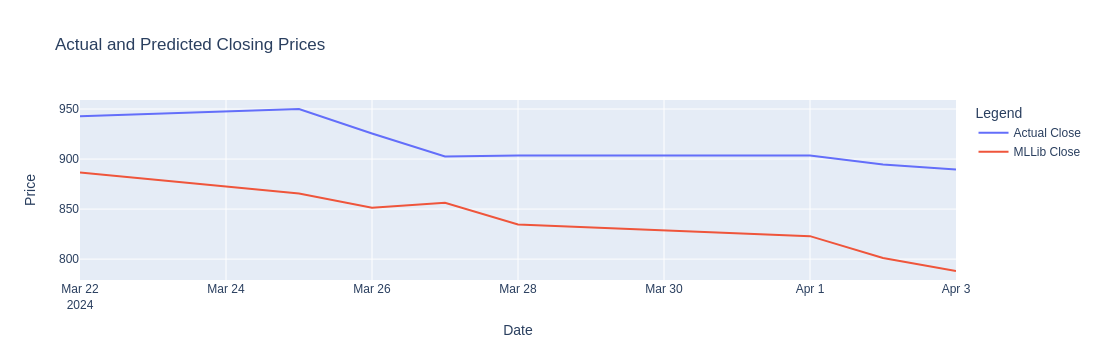

In [31]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)

trace2 = go.Scatter(
    x=merged_df.index,
    y=merged_df['MLLib_Close'],
    mode='lines',
    name='MLLib Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


MAE (Mean Absolute Error): It represents the average absolute difference between the predicted and actual values. A lower MAE indicates better model performance.

MSE (Mean Squared Error): It measures the average of the squares of the errors. A lower MSE suggests better model performance.

RMSE (Root Mean Squared Error): It is the square root of the MSE. It represents the standard deviation of the differences between the predicted and actual values. A lower RMSE indicates better model performance.

In [32]:
# Hata metriklerini hesaplayın
errors = merged_df['Close'] - merged_df['MLLib_Close']
mae = np.mean(np.abs(errors))
mse = np.mean(np.square(errors))
rmse = np.sqrt(mse)

print(f"MAE: {mae}") # Mean Absolute Error - MAE
print(f"MSE: {mse}") # Mean Squared Error - MSE
print(f"RMSE: {rmse}") # Root Mean Squared Error - RMSE

MAE: 75.71337912757637
MSE: 6029.339982471225
RMSE: 77.64882473335463


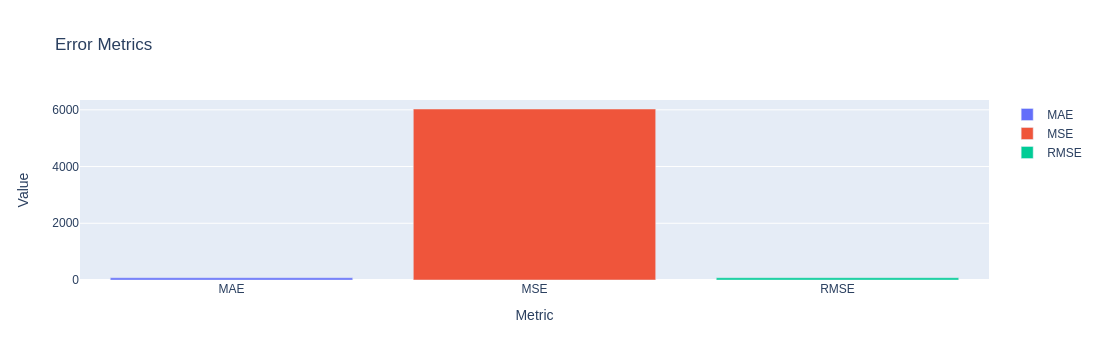

In [33]:
import plotly.graph_objs as go

# Örnek veriler
hata = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae, mse, rmse]
}
# Bar grafiği oluşturun ve efsane (legend) özelliğini aktifleştirin
traces = []
for metric, value in zip(hata['Metrics'], hata['Values']):
    traces.append(go.Bar(x=[metric], y=[value], name=metric))

fig = go.Figure(data=traces)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()

# ARIMA

  The ARIMA model is a popular choice for the analysis of financial time series because it has the capability to capture non-linear trends and seasonal fluctuations. Financial data, like closing prices, often exhibit regular patterns and trends over time, and ARIMA allows us to model these trends for future forecasting. This model is also quite effective in extracting meaningful information from noisy datasets and determining relationships between data. For this reason I chose the ARIMA model for comparison with my previous MLLib

This time I read the data using pandas rather than pyspark since we will be using ARIMA. I then converted the data in the 'Date' column to date format and assigned this column as an index so that the data was ready for time series analysis. I visualized the closing prices of the stock as a time series in the form of a line chart so that I could observe trends and fluctuations in the data.

In [34]:
df_arima = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [35]:
df_arima.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [36]:
# Tarih sütununu datetime tipine çevirelim ve indeks olarak ayarlayalım
df_arima["Date"] = pd.to_datetime(df_arima["Date"])
df_arima.set_index("Date", inplace=True)

# Veri setinin son halini gösterelim
df_arima.head()


,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [37]:
#!pip install statsmodels

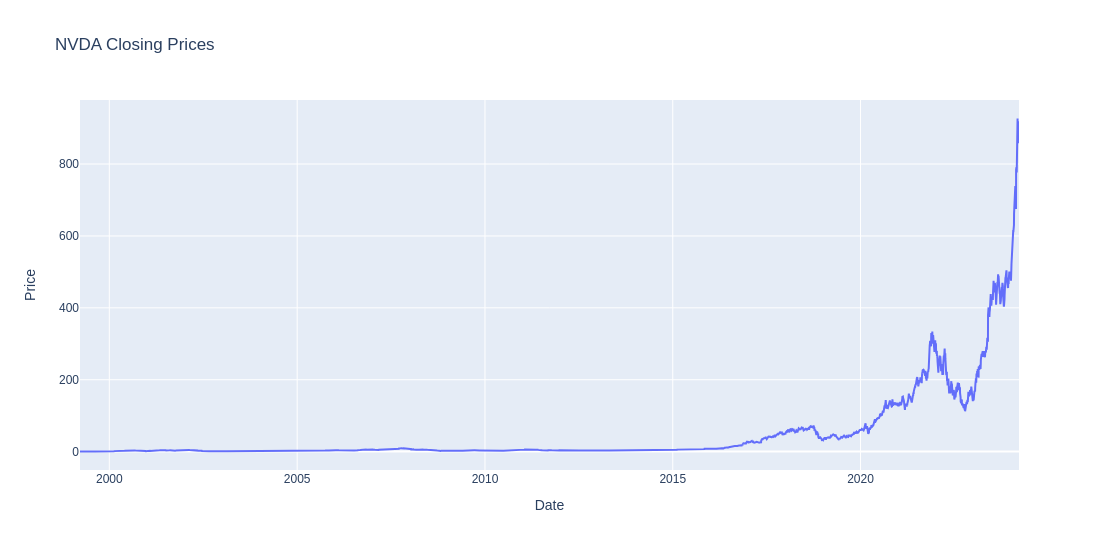

In [38]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=df_arima.index,
    y=df_arima['Close'],
    mode='lines',
    name='Closing price'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1])
fig.update_layout(
    title='NVDA Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    width = 1100, 
    height = 550
    #legend_title='Legend'
)

fig.show()


## Stationarity test

- In this code block, I first perform the Augmented Dickey-Fuller (ADF) test using the adfuller function. The ADF test tests whether the series contains a unit root, that is, whether the time series is stationary. Stationarity is one of the assumptions of time series models and determines whether the series has a constant mean and variance over time, which is necessary for models such as ARIMA to make accurate predictions.
- Outputs such as the test statistic and the p-value give an idea whether the series is stationary or not. A p-value of less than 0.05 usually indicates that the series is stationary. Here, however, the p-value is 1.0, indicating that the series is non-stationary.
- Next, we take the first difference of the closing stock prices. First differencing attempts to make the series stationary by reducing the trend and seasonality, if any. After taking the difference, we plot the difference series with the df_diff.plot() function, which provides a visual representation of the stationarity of the series.

In [39]:
# Let's test for stationarity (Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_arima["Close"])
adf_test_output = {"Test Statistic": adf_test[0], "p-value": adf_test[1], "Critical Values": adf_test[4]}
adf_test_output

{'Test Statistic': 5.155957114554979,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.43139554655334,
  '5%': -2.8620020389491527,
  '10%': -2.5670159403767285}}

In [40]:
df_diff = df_arima["Close"].diff().dropna()

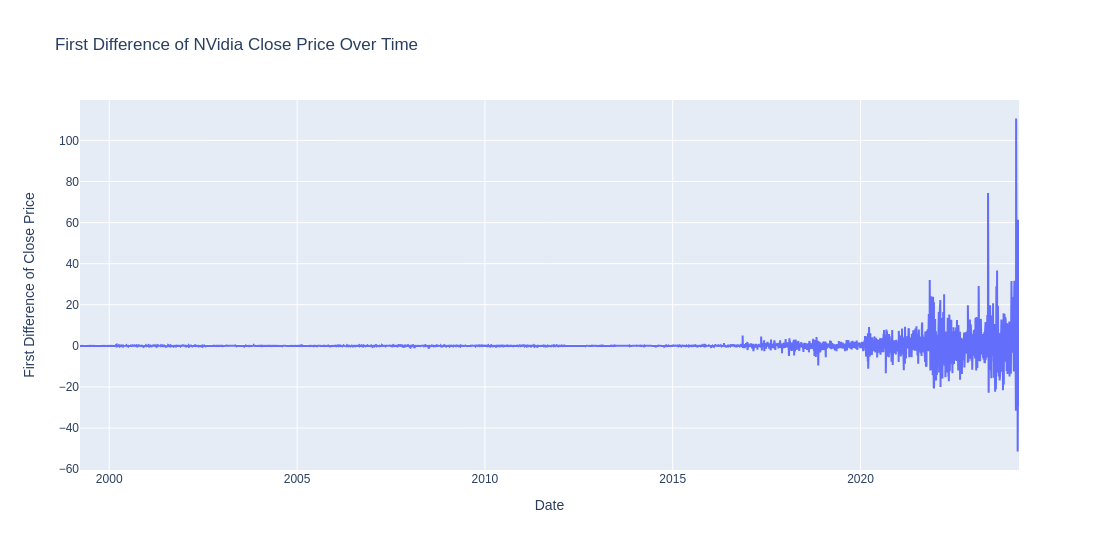

In [41]:
# Let's graph the first difference
# Create Plotly Scatter objects
trace_df_diff = go.Scatter(
    x=df_diff.index,
    y=df_diff,
    mode='lines',
    name='Closing price'
)
# Create and show the combined graph
fig = go.Figure(data=[trace_df_diff])
fig.update_layout(
    title='First Difference of NVidia Close Price Over Time',
    xaxis_title='Date',
    yaxis_title='First Difference of Close Price',
    width = 1100, 
    height = 550
    #legend_title='Legend'
)
fig.show()

After taking the first differences, I performed the ADF test again to check for stationarity of the series. I ran the adfuller function on my differenced series this time and the results included the test statistic and p-value. With the test statistic around -5.75 and the p-value below 0.05, I can now say that my series is stationary and in a suitable condition for ARIMA modeling. Stationarity means that the statistical properties of the time series data (like mean, variance, and autocorrelation) do not change over time, thereby providing a more reliable foundation for forecasting models.

In [42]:
# Let's test for stationarity again
adf_test_diff = adfuller(df_diff)
adf_test_diff_output = {"Test Statistic": adf_test_diff[0], "p-value": adf_test_diff[1], "Critical Values": adf_test_diff[4]}
adf_test_diff_output

{'Test Statistic': -5.757858629267697,
 'p-value': 5.76359951481798e-07,
 'Critical Values': {'1%': -3.431395379411139,
  '5%': -2.8620019651000943,
  '10%': -2.567015901065109}}

The ACF (Autocorrelation Function) measures the correlation of the time series data at different time lags and helps me determine the AR (Autoregressive) terms for the model. The PACF (Partial Autocorrelation Function) measures the correlation at each lag after controlling for the correlations due to the terms at all shorter lags and aids in selecting the MA (Moving Average) terms. These plots are used while determining the p, d, q parameters of the ARIMA model, where ‘p’ is the number of AR terms, ‘d’ is the number of differencing required to make the series stationary, and ‘q’ is the number of MA terms. By interpreting the ACF and PACF plots, I decided which parameters would make my model perform best.

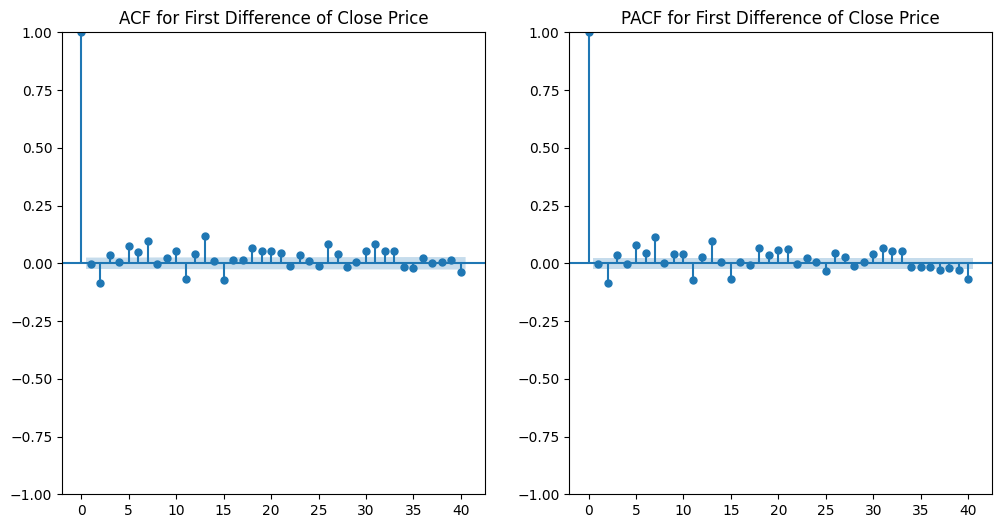

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF ve PACF grafiklerini çizdirelim
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Otomatik Çapraz Korelasyon Fonksiyonu (ACF)
plot_acf(df_diff, ax=ax1, lags=40, alpha=0.05)
ax1.set_title("ACF for First Difference of Close Price")

# Kısmi Otomatik Çapraz Korelasyon Fonksiyonu (PACF)
plot_pacf(df_diff, ax=ax2, lags=40, alpha=0.05)
ax2.set_title("PACF for First Difference of Close Price")

plt.show()


In this step, I used the ARIMA module from the statsmodels library to construct and train an ARIMA model on the stock closing prices. I set the order parameter of the model to (1, 1, 1); this indicates one AR term, one differencing operation, and one MA term, which I chose based on the information I gathered from the ACF and PACF plots. After fitting the model, I obtained a summary with model_fit.summary() and reviewed the results. The model summary includes information like the AIC and BIC, which are metrics that will help me assess how well the model fits, as well as the coefficients, standard errors, and results of other statistical tests. I use this information to understand how well the model fits the data and how reliable its forecasts might be.

In [44]:
from statsmodels.tsa.arima.model import ARIMA
df_arima = df_arima.asfreq('B')

# ARIMA modelini kurma ve eğitme
model = ARIMA(df_arima["Close"], order=(1, 1, 1))
model_fit = model.fit()

# Model özeti
model_summary = model_fit.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6524
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17217.616
Date:                Thu, 04 Apr 2024   AIC                          34441.231
Time:                        00:20:45   BIC                          34461.581
Sample:                    03-22-1999   HQIC                         34448.268
                         - 03-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9080      0.006   -158.403      0.000      -0.919      -0.897
ma.L1          0.9537      0.005    206.723      0.000       0.945       0.963
sigma2        13.5654      0.030    446.404      0.0

To make my predictions, I used an ARIMA model with steps equal to the number of working days.
Then, I converted the predictions into a DataFrame and placed them in a column called 'ARIMA_Close'. I mapped the index of this DataFrame to dates and named the index 'Date'.

In [45]:
# Pandas kullanarak iş günleri sayısını ve toplam gün sayısını hesaplayacağız
start_arima = df_arima.index.max()

# Bugünün tarihini alalım
end_arima = pd.to_datetime("today").normalize()  # Saat bilgisi olmadan bugünün tarihi

# İş günlerini hesaplayalım
business_days = pd.bdate_range(start=start_arima, end=end_arima)

# İş günleri ve toplam gün sayısını -1 ile başlatalım çünkü başlangıç gününü saymıyoruz
weekdays_count_arima = len(business_days) -1
total_days_arima = (end_arima - start_arima).days 
weekdays_count_arima, total_days_arima

(10, 14)

In [46]:
forecast_steps = weekdays_count_arima # sonraki is gunleri 
# Sonraki iş günleri için tahmin yapma
forecast = model_fit.forecast(steps=forecast_steps)

# Doğru tarih aralığını ve tahminleri alalım
forecast_dates = pd.date_range(start=df_arima.index[-1], periods=forecast_steps, freq='B')
forecast_values = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Uyuşmazlık olmaması için tarihlerin ve tahminlerin sayısının aynı olduğundan emin olalım
forecast_dates = forecast_dates[1:]  # İlk tarihi hariç tutuyoruz çünkü tahmin başlangıcı mevcut verinin sonrası olmalı

# Sonuçları bir DataFrame'e dönüştürüyoruz
df_arima_forecast = pd.DataFrame({"ARIMA_Close": forecast_values })
df_arima_forecast.rename_axis("Date", inplace=True)
df_arima_forecast

,ARIMA_Close
Date,
2024-03-22,915.961616
2024-03-25,914.498229
2024-03-26,915.827000
2024-03-27,914.620462
2024-03-28,915.716012
2024-03-29,914.721241
2024-04-01,915.624504
2024-04-02,914.804331
2024-04-03,915.549057


we have now added ARIMA results to the data we have previously combined

In [47]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df = merged_df.join(df_arima_forecast, how='inner')
merged_df

,Close,MLLib_Close,ARIMA_Close
Date,,,
2024-03-22,942.890015,886.600169,915.961616
2024-03-25,950.020020,865.577338,914.498229
2024-03-26,925.609985,851.413442,915.827000
2024-03-27,902.500000,856.218773,914.620462
2024-03-28,903.559998,834.705000,915.716012
2024-04-01,903.630005,822.975599,915.624504
2024-04-02,894.520020,801.048418,914.804331
2024-04-03,889.640015,788.124285,915.549057


now we have created a graph to compare this value and in this graph we can compare the actual closing values with MLLib forecasts and ARIMA forecasts.

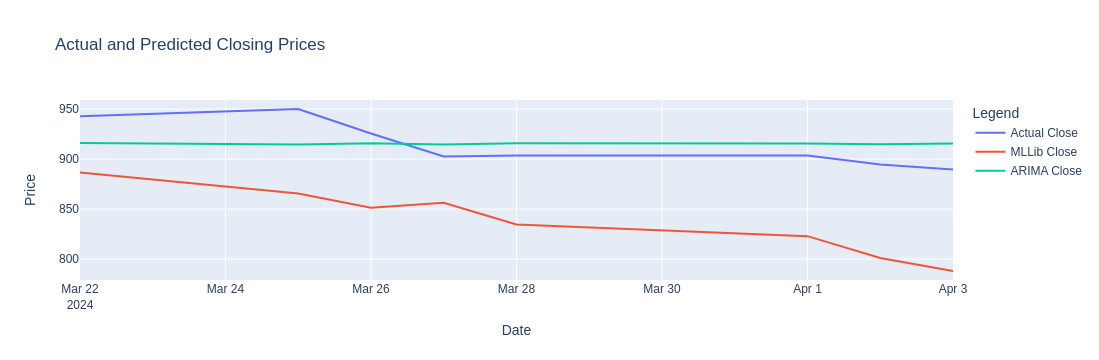

In [48]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace_actual = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)
trace_MLLib = go.Scatter(
    x=merged_df.index,
    y=merged_df['MLLib_Close'],
    mode='lines',
    name='MLLib Close'
)
trace_ARIMA = go.Scatter(
    x=merged_df.index,
    y=merged_df['ARIMA_Close'],
    mode='lines',
    name='ARIMA Close'
)
# Create and show the combined graph
fig = go.Figure(data=[trace_actual, trace_MLLib,trace_ARIMA])
#fig = go.Figure(data=[trace_arima_actual])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


In [49]:
# I calculated ARIMA error metrics
errors = merged_df['Close'] - merged_df['ARIMA_Close']
mae_arima = np.mean(np.abs(errors))
mse_arima = np.mean(np.square(errors))
rmse_arima = np.sqrt(mse_arima)

print(f"MAE: {mae_arima}") # Mean Absolute Error - MAE
print(f"MSE: {mse_arima}") # Mean Squared Error - MSE
print(f"RMSE: {rmse_arima}") # Root Mean Squared Error - RMSE

MAE: 19.33718775025912
MSE: 450.4896310368328
RMSE: 21.224741012244007


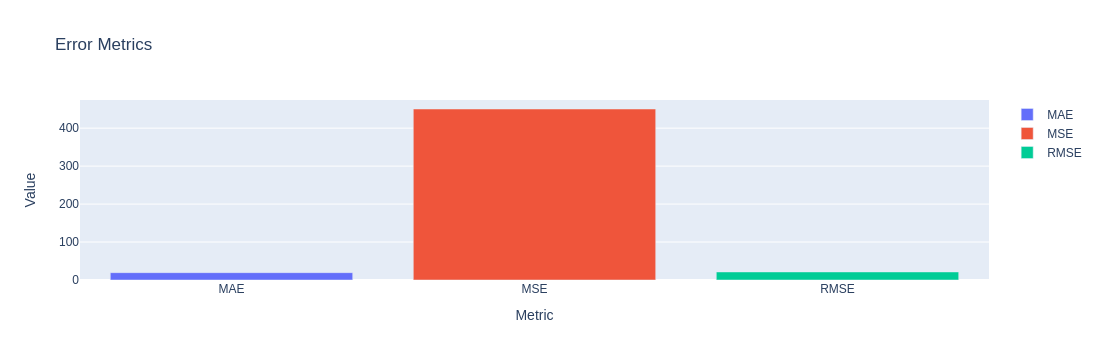

In [50]:
# Let's plot the ARIMA error metrics
hata_arima = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae_arima, mse_arima, rmse_arima]
}

# Her bir metrik için bir go.Bar oluşturup bir listeye ekleyin
traces_arima = [go.Bar(x=[metric], y=[value], name=metric) for metric, value in zip(hata_arima['Metrics'], hata_arima['Values'])]

# go.Figure ile grafiği oluşturun
fig = go.Figure(data=traces_arima)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()


# LSTM

In [51]:
df_LSTM = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [52]:
df_LSTM.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [53]:
# Tarih sütununu datetime tipine çevirelim ve indeks olarak ayarlayalım
df_LSTM["Date"] = pd.to_datetime(df_LSTM["Date"])
df_LSTM.set_index("Date", inplace=True)

# Veri setinin son halini gösterelim
df_LSTM.head()


,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [54]:
df_LSTM.isnull().sum()

Close    0
dtype: int64

In [55]:
#!pip install scikit-learn
#!pip install keras
#!pip install tensorflow

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_LSTM)

# Eğitim ve test setlerine ayırma
train_size = int(len(df_scaled) * 0.80)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]

In [57]:
import numpy as np

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [58]:
#pip install tensorflow
#pip install tensorflow==2.16.1

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Örnek olarak, eğer her bir zaman adımında sadece 1 özellik (örneğin sadece kapanış fiyatı) varsa:
input_shape = (look_back, 1)

# Eğer birden fazla özellik varsa (örneğin hem kapanış fiyatı hem de hacim):
#input_shape = (look_back, 2)  # Bu, kullanılan özellik sayısına göre değişebilir

# Modelinizi oluşturun
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

2024-04-04 00:20:46.009836: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 00:20:46.040409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 00:20:46.646088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-04 00:20:47.130607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 00:20:47.153396: 

In [60]:
# Modelinizi eğitim verileri ile eğitin
# Bu kod bloğu, X_train'in ve y_train'in uygun şekilde hazırlandığını varsayar
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
158/158 - 1s - 8ms/step - loss: 1.5144e-04
Epoch 2/10
158/158 - 0s - 1ms/step - loss: 4.1519e-07
Epoch 3/10
158/158 - 0s - 975us/step - loss: 3.2130e-07
Epoch 4/10
158/158 - 0s - 959us/step - loss: 3.3276e-07
Epoch 5/10
158/158 - 0s - 958us/step - loss: 3.5908e-07
Epoch 6/10
158/158 - 0s - 944us/step - loss: 3.1945e-07
Epoch 7/10
158/158 - 0s - 1ms/step - loss: 3.5131e-07
Epoch 8/10
158/158 - 0s - 1ms/step - loss: 3.7202e-07
Epoch 9/10
158/158 - 0s - 910us/step - loss: 4.4161e-07
Epoch 10/10
158/158 - 0s - 936us/step - loss: 3.7606e-07


In [61]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
Train Score: 16.97 RMSE
Test Score: 260.16 RMSE


In [62]:
#!pip install keras-tuner

In [63]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch

# Model oluşturmak için fonksiyon
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)))  # X_train'in özellik sayısına bağlı olarak şekil değişebilir
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

# Tuner'ı tanımla
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_example' )

Reloading Tuner from my_dir/keras_tuner_example/tuner0.json


In [64]:
# Tuner ile hiperparametre aramasını başlat
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5)])

In [65]:
best_hps = tuner.get_best_hyperparameters()[0]
print(f"En iyi hiperparametreler: {best_hps.values}")
#print(f"En iyi kayıp değeri (val_loss): {tuner.results_summary()}")

En iyi hiperparametreler: {'units': 64, 'dropout': 0.0, 'learning_rate': 0.001}


In [66]:
# En iyi hiperparametreleri al ve modeli yeniden oluştur
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7225e-06 - mean_squared_error: 4.7225e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5797e-06 - mean_squared_error: 3.5797e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6331e-06 - mean_squared_error: 3.6331e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4858e-06 - mean_squared_error: 3.4858e-06 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1046e-06 - mean_squared_error: 4.1046e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5237e-06 - mean_squared_error: 3.5237e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.72

In [67]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
#train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
#test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.4f} RMSE')
print(f'Test Score: {test_score:.4f} RMSE')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
Train Score: 0.0029 RMSE
Test Score: 0.0432 RMSE


In [68]:
model.save("modelim.h5")

In [69]:
df_real_close

,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998
2024-04-01,903.630005
2024-04-02,894.520020
2024-04-03,889.640015


In [70]:
df_LSTM.tail()

,Close
Date,
2024-03-15,878.369995
2024-03-18,884.549988
2024-03-19,893.979980
2024-03-20,903.719971
2024-03-21,914.349976


In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib 
import datetime as dt

In [ ]:
# Model ve scaler yükleniyor. Yolları kontrol edin.
model = load_model("modelim.h5")
scaler = joblib.load("scaler.joblib")


In [72]:
close_prices = df_LSTM["Close"].values.reshape(-1, 1)

# Ölçeklenmiş son 10 fiyatı almak için:
look_back = 10  # Burada kaç önceki adımı kullanmak istediğinizi belirtin
last_prices_scaled = scaler.transform(close_prices[-look_back:])

# Tahminler için bir dizi oluşturun.
predictions = []

In [73]:
def predict_next_n_days(model, normalized_data, look_back, weekdays_count_LSTM):
    predictions = []
    # Normalleştirilmiş verileri modelin beklediği şekle getirme
    close_prices = df_LSTM["Close"].values.reshape(-1, 1)
    last_prices_scaled = scaler.transform(close_prices[-look_back:])
    # Tahminler için bir dizi oluşturun.
    predictions = []
    for i in range(weekdays_count_LSTM):
        # Model tahminini yapın ve sonucu ölçeklendirmeyi tersine çevirin.
        predicted_price_normalized = model.predict(last_prices_scaled)
        predicted_price_normalized = predicted_price_normalized.reshape(look_back, 1)
        predicted_price = scaler.inverse_transform(predicted_price_normalized)[1, -1]
        
        # Tahmin listesine ekleyin.
        predictions.append(predicted_price)
        
        # Son tahmin edilen fiyatı ölçeklendirin ve ölçeklenmiş fiyatlar listesine ekleyin.
        last_price_scaled = np.append(last_prices_scaled, predicted_price_normalized)[-look_back:]
        last_prices_scaled = last_prices_scaled.reshape(-1, 1)
    
    return predictions

In [74]:
predicted_prices = predict_next_n_days(model, close_prices, look_back, weekdays_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [83]:
#end_LSTM
# Tahmin tarihlerini oluşturun.
start_LSTM = df_LSTM.index.max()  + pd.Timedelta(days=1)
start_LSTM
predicted_dates = pd.date_range(start=start_LSTM, periods=weekdays_count, freq='B')

# Tahminleri içeren DataFrame oluşturun.
predictions_df = pd.DataFrame(data=predicted_prices, index=predicted_dates, columns=["Predicted_Close"])
predictions_df.index.name = "Date"
predictions_df

,Predicted_Close
Date,
2024-03-22,741.213684
2024-03-25,751.572937
2024-03-26,761.119690
2024-03-27,768.959961
2024-03-28,778.026489
2024-03-29,787.474426
2024-04-01,794.499390
2024-04-02,798.534485
2024-04-03,800.379272


In [84]:
# Kütüphaneleri yükle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import joblib


# Kapanış fiyatlarını seç
closing_prices = df_LSTM['Close'].values.reshape(-1, 1)

# Verileri ölçeklendir
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Verileri eğitim ve test setlerine ayır
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# LSTM için veri setini yeniden şekillendirme fonksiyonu
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


In [110]:
# Eğitim ve test veri setlerini oluştur
look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# LSTM modelini oluştur
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Modeli derle
model.compile(loss='mean_squared_error', optimizer='adam')

# Modeli eğit
model.fit(X_train, y_train, epochs=100, batch_size=16384, verbose=2)  # Daha fazla epoch ile daha iyi sonuçlar alabilirsiniz

Epoch 1/1000
1/1 - 1s - 1s/step - loss: 3.1031e-04
Epoch 2/1000
1/1 - 0s - 92ms/step - loss: 2.3092e-04
Epoch 3/1000
1/1 - 0s - 97ms/step - loss: 2.6225e-04
Epoch 4/1000
1/1 - 0s - 105ms/step - loss: 2.1086e-04
Epoch 5/1000
1/1 - 0s - 103ms/step - loss: 1.7229e-04
Epoch 6/1000
1/1 - 0s - 124ms/step - loss: 1.7519e-04
Epoch 7/1000
1/1 - 0s - 117ms/step - loss: 1.7557e-04
Epoch 8/1000
1/1 - 0s - 110ms/step - loss: 1.4845e-04
Epoch 9/1000
1/1 - 0s - 112ms/step - loss: 1.1718e-04
Epoch 10/1000
1/1 - 0s - 107ms/step - loss: 1.0746e-04
Epoch 11/1000
1/1 - 0s - 104ms/step - loss: 1.0930e-04
Epoch 12/1000
1/1 - 0s - 104ms/step - loss: 9.3635e-05
Epoch 13/1000
1/1 - 0s - 103ms/step - loss: 6.6071e-05
Epoch 14/1000
1/1 - 0s - 106ms/step - loss: 5.2901e-05
Epoch 15/1000
1/1 - 0s - 98ms/step - loss: 5.4502e-05
Epoch 16/1000
1/1 - 0s - 102ms/step - loss: 4.2345e-05
Epoch 17/1000
1/1 - 0s - 96ms/step - loss: 2.0504e-05
Epoch 18/1000
1/1 - 0s - 97ms/step - loss: 1.7499e-05
Epoch 19/1000
1/1 - 0s - 95

In [111]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.4f} RMSE')
print(f'Test Score: {test_score:.4f} RMSE')

# İş günleri için tarih aralığı oluştur
last_date = df_LSTM.index[-1] + pd.Timedelta(days=1)
dates = pd.bdate_range(start=last_date, periods=weekdays_count, freq='B')

# Tahminleri yap
predictions = model.predict(X_test)[-weekdays_count:] # Test setinin sonundan alınan 6 tahmin
predicted_prices = scaler.inverse_transform(predictions)

# Tahminleri içeren DataFrame oluştur
predictions_df = pd.DataFrame(data=predicted_prices, index=dates, columns=['Predicted_Close'])
predictions_df.index.name = "Date"
predictions_df

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 0.8888 RMSE
Test Score: 25.2545 RMSE
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Predicted_Close
Date,
2024-03-22,735.000793
2024-03-25,746.739746
2024-03-26,756.856018
2024-03-27,764.288879
2024-03-28,772.838562
2024-03-29,781.291077
2024-04-01,786.913391
2024-04-02,789.688354
2024-04-03,790.692505


In [95]:
predictions_df = predict_next_n_days(model, close_prices, look_back, weekdays_count)
predictions_df

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [96]:
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM modelini oluştur
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
# Modeli derle
model.compile(loss='mean_squared_error', optimizer='adam')
# Modeli eğit
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.4f} RMSE')
print(f'Test Score: {test_score:.4f} RMSE')

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.6140e-05
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4436e-06
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9239e-06
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7022e-06
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6851e-06
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3306e-06
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1751e-06
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0363e-06
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1628e-06
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3638e-06
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 0.9000 RMSE
Test Score: 26.6671 RMSE


In [98]:
# İş günleri için tarih aralığı oluştur
last_date = df_LSTM.index[-1] + pd.Timedelta(days=1)
dates = pd.bdate_range(start=last_date, periods=weekdays_count, freq='B')

# Tahminleri yap
predictions = model.predict(X_test)[-weekdays_count:] # Test setinin sonundan alınan 6 tahmin
predicted_prices = scaler.inverse_transform(predictions)

# Tahminleri içeren DataFrame oluştur
predictions_df = pd.DataFrame(data=predicted_prices, index=dates, columns=['Predicted_Close'])
predictions_df.index.name = "Date"
predictions_df

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Predicted_Close
Date,
2024-03-22,730.986572
2024-03-25,744.520813
2024-03-26,754.419861
2024-03-27,760.061707
2024-03-28,767.593872
2024-03-29,774.748474
2024-04-01,778.446350
2024-04-02,779.544434
2024-04-03,779.547241
